In [2]:
from __future__ import print_function, division
import argparse
import numpy as np
from sklearn.cluster import KMeans
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.optim import Adam
from torch.nn import Linear

#from evaluation import eva
from torch.utils.data import DataLoader, TensorDataset
import h5py
import scanpy as sc

import pandas as pd

import time
import scipy as sp
import matplotlib.pyplot as plt
#from layers import ZINBLoss, MeanAct, DispAct
#from GNN import GNNLayer
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

## Parameters

In [3]:
File = ['Romanov', "mtab", 'model/mtab.pkl', "data/mtab.h5"]
# model_para = [n_enc_1(n_dec_3), n_enc_2(n_dec_2), n_enc_3(n_dec_1), n_cluster, n_init]
model_para = [512, 256, 64]
#model_para = [512, 256, 256]
# Para = [batch_size, lr, epoch]
Para = [1024, 1e-4, 200]
Fileformat = ['data.h5','csv','dataset.h5']
# Cluster_para = [n_cluster, n_z, n_input, n_init]
Cluster_para = [7, 32, 2000, 20]
# Balance_para = [binary_crossentropy_loss, ce_loss, re_loss, zinb_loss]
#Balance_para = [0.1, 0.01, 1, 0.1]
#Balance_para = [0.1, 0.2, 0.3, 0.4]
Method = ['pearson','spearman','NE']
parser = argparse.ArgumentParser(
        description='train',
        formatter_class=argparse.ArgumentDefaultsHelpFormatter)

parser.add_argument('--name', type=str, default=File[0])
parser.add_argument('--graph', type=str, default=File[1])
parser.add_argument('--pretrain_path', type=str, default=File[2])
parser.add_argument('--n_enc_1', default=model_para[0], type=int)
parser.add_argument('--n_enc_2', default=model_para[1], type=int)
parser.add_argument('--n_enc_3', default=model_para[2], type=int)
parser.add_argument('--n_dec_1', default=model_para[2], type=int)
parser.add_argument('--n_dec_2', default=model_para[1], type=int)
parser.add_argument('--n_dec_3', default=model_para[0], type=int)
parser.add_argument('--method', default=Method[2], type=str)
parser.add_argument('--k', type=int, default=None)
parser.add_argument('--lr', type=float, default=Para[1])
parser.add_argument('--epoch', type=int, default=Para[2])
parser.add_argument('--n_clusters', default=Cluster_para[0], type=int)
parser.add_argument('--n_z', default=Cluster_para[1], type=int)
parser.add_argument('--n_input', type=int, default=Cluster_para[2])
parser.add_argument('--n_init', type=int, default=Cluster_para[3])
parser.add_argument('--format', type=str, default=Fileformat[0])

args = parser.parse_args([])
args.cuda = torch.cuda.is_available()
print("use cuda: {}".format(args.cuda))

device = torch.device("cuda" if args.cuda else "cpu")
args.pretrain_path = File[2]
start = time.time()

use cuda: True


### data.h5 function

In [4]:
class dotdict(dict):
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

def empty_safe(fn, dtype):
    def _fn(x):
        if x.size:
            return fn(x)
        return x.astype(dtype)
    return _fn

decode = empty_safe(np.vectorize(lambda _x: _x.decode("utf-8")), str)

def read_clean(data):
    assert isinstance(data, np.ndarray)
    if data.dtype.type is np.bytes_:
        data = decode(data)
    if data.size == 1:
        data = data.flat[0]
    return data

def dict_from_group(group):
    assert isinstance(group, h5py.Group)
    d = dotdict()
    for key in group:
        if isinstance(group[key], h5py.Group):
            value = dict_from_group(group[key])
        else:
            value = read_clean(group[key][...])
        d[key] = value
    return d

def read_clean(data):
    assert isinstance(data, np.ndarray)
    if data.dtype.type is np.bytes_:
        data = decode(data)
    if data.size == 1:
        data = data.flat[0]
    return data

def prepro(filename):
    #data_path = "data/Quake_10x_Bladder/data.h5"
    data_path = "data/" + filename + "/data.h5"
    mat, obs, var, uns = read_data(data_path, sparsify=False, skip_exprs=False)
    if isinstance(mat, np.ndarray):
        X = np.array(mat)
    else:
        X = np.array(mat.toarray())
    cell_name = np.array(obs["cell_type1"])
    #cell_name2 = np.array(obs["names"])
    #print(cell_name2)
    cell_type, cell_label = np.unique(cell_name, return_inverse=True)
    return X, cell_label,var

def read_data(filename, sparsify = False, skip_exprs = False):
    
    with h5py.File(filename, "r") as f:
        obs = pd.DataFrame(dict_from_group(f["obs"]), index = decode(f["obs_names"][...]))
        var = pd.DataFrame(dict_from_group(f["var"]), index = decode(f["var_names"][...]))
        uns = dict_from_group(f["uns"])
        if not skip_exprs:
            exprs_handle = f["exprs"]
            if isinstance(exprs_handle, h5py.Group):
                mat = sp.sparse.csr_matrix((exprs_handle["data"][...], exprs_handle["indices"][...],
                                               exprs_handle["indptr"][...]), shape = exprs_handle["shape"][...])
            else:
                mat = exprs_handle[...].astype(np.float32)
                if sparsify:
                    mat = sp.sparse.csr_matrix(mat)
        else:
            mat = sp.sparse.csr_matrix((obs.shape[0], var.shape[0]))
    return mat, obs, var, uns

## Read datasets

In [5]:
if args.format == 'data.h5':
        X,Y,var = prepro(args.name)
        X = np.ceil(X).astype(int)
        count_X = X
        adata = sc.AnnData(X,dtype='float32')
        #var = var.iloc[:, 0]
        adata.var_names = var.index


        #adata.var_names=var
        adata.obs['Group'] = Y
elif args.format == 'csv':
        adata=sc.read_csv('data/PBMC/pbmc.csv')
        #adata=adata.T 
        y= pd.read_csv('data/PBMC/clusters.csv', index_col=0)
        y= np.array(y.values)
        adata.obs['Group'] = y
        adata.var_names_make_unique()
elif args.format == 'dataset.h5':
        data_mat = h5py.File('data/Romanov.h5')
        x = np.array(data_mat['X'])
        x=x.T
        y = np.array(data_mat['Y'])
        data_mat.close()
        #print(x.shape)
        #print(y.shape)

# preprocessing scRNA-seq read counts matrix
        adata = sc.AnnData(x,dtype='float32')
        adata.obs['Group'] = y
else:
        print(f'Unknown name: {args.name}')

In [6]:
var

""
Xkr4
Rp1
Sox17
Mrpl15
Lypla1
...
Sly_loc3
Gm20738_loc1
Gm20809_loc4
Sly_loc1


In [7]:
adata.var_names

Index(['Xkr4', 'Rp1', 'Sox17', 'Mrpl15', 'Lypla1', 'Tcea1', 'Rgs20', 'Atp6v1h',
       'Oprk1', 'Npbwr1',
       ...
       'Gm20871_loc2', 'Gm20738_loc4', 'Gm20871_loc3', 'Sly_loc2',
       'LOC100040786_loc2', 'Sly_loc3', 'Gm20738_loc1', 'Gm20809_loc4',
       'Sly_loc1', 'Erdr1'],
      dtype='object', length=21143)

## Data preprocessing

In [8]:
from sklearn.model_selection import train_test_split
import random

def read_dataset(adata, transpose=False, test_split=False, copy=False):
    if isinstance(adata, sc.AnnData):
        if copy:
            adata = adata.copy()
    elif isinstance(adata, str):
        adata = sc.read(adata)
    else:
        raise NotImplementedError

    norm_error = 'Make sure that the dataset (adata.X) contains unnormalized count data.'
    assert 'n_count' not in adata.obs, norm_error

    if adata.X.size < 50e6:  # check if adata.X is integer only if array is small
        if sp.sparse.issparse(adata.X):
            assert (adata.X.astype(float) != adata.X).nnz == 0, norm_error
        else:
            assert np.all(adata.X.astype(float) == adata.X), norm_error

    if transpose: adata = adata.transpose()

    if test_split:
        train_idx, test_idx = train_test_split(np.arange(adata.n_obs), test_size=0.1, random_state=42)
        spl = pd.Series(['train'] * adata.n_obs)
        spl.iloc[test_idx] = 'test'
        adata.obs['DCA_split'] = spl.values
    else:
        adata.obs['DCA_split'] = 'train'

    adata.obs['DCA_split'] = adata.obs['DCA_split'].astype('category')
    print('### Autoencoder: Successfully preprocessed {} genes and {} cells.'.format(adata.n_vars, adata.n_obs))

    return adata

def normalize(adata, filter_min_counts=True, size_factors=True, normalize_input=True, logtrans_input=True, select_hvg=True,down_sampling=True):

    if filter_min_counts:
        sc.pp.filter_genes(adata, min_counts=1)
        sc.pp.filter_cells(adata, min_counts=1)

    if logtrans_input:
        sc.pp.log1p(adata)

    if down_sampling:
        n_cells = adata.n_obs
        n_sampled_cells = int(n_cells * 1)
        random_cell_indices = random.sample(range(n_cells), n_sampled_cells)
        adata = adata[random_cell_indices, :]
    if select_hvg:
        sc.pp.highly_variable_genes(adata, n_top_genes=2000)
        adata = adata[:, adata.var.highly_variable]

    if size_factors or normalize_input or logtrans_input or select_hvg:
        adata.raw = adata.copy()
    else:
        adata.raw = adata

    if size_factors:
        sc.pp.normalize_per_cell(adata)
        adata.obs['size_factors'] = adata.obs.n_counts / np.median(adata.obs.n_counts)
    else:
        adata.obs['size_factors'] = 1.0

    #if logtrans_input:
        #sc.pp.log1p(adata)

    if normalize_input:
        sc.pp.scale(adata)

    return adata


adata = read_dataset(adata,
                         transpose=False,
                         test_split=False,
                         copy=True)
adata = normalize(adata,
                size_factors=True,
                normalize_input=True,
                logtrans_input=True,
                select_hvg=True)
X = adata.X
X=X.T
X_raw = adata.raw.X.T
sf = adata.obs.size_factors #size_factors

### Autoencoder: Successfully preprocessed 21143 genes and 2881 cells.


e:\anaconda\envs\torch_gpu\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:544: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['hvg'] = {'flavor': flavor}


## Cell graph construction function

In [9]:
from scipy.stats import spearmanr
import scipy.sparse as sp
def normalize_NE(mx):
    # Row-normalize sparse matrix
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx
def getGraph( features, L, K, method):
    print(method)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    features=features.T
    if method == 'pearson':
        co_matrix = np.corrcoef(features)
    elif method == 'spearman':
        co_matrix, _ = spearmanr(features.T)
    elif method == 'NE':
        co_matrix = np.corrcoef(features)

        NE_path = 'result/NE.csv'
        """ if os.path.exists(NE_path):
            NE_matrix = pd.read_csv(NE_path).values
        else: """
        #features = normalization_for_NE(features)
        in_matrix = np.corrcoef(features)
        NE_matrix = getNeMatrix(in_matrix)
        pd.DataFrame(NE_matrix).to_csv(NE_path, index=False)

        N = len(co_matrix)
        sim_sh = 1.
        for i in range(len(NE_matrix)):
            NE_matrix[i][i] = sim_sh * max(NE_matrix[i])
        
        data = NE_matrix.reshape(-1)
        data = np.sort(data)# np.sort()
        data = data[:-int(len(data)*0.02)]
        
        min_sh = data[0]
        max_sh = data[-1]
        delta = (max_sh - min_sh) / 100
    
        temp_cnt = []
        for i in range(20):
            s_sh = min_sh + delta * i
            e_sh = s_sh + delta
            temp_data = data[data > s_sh]
            temp_data = temp_data[temp_data < e_sh]
            temp_cnt.append([(s_sh + e_sh)/2, len(temp_data)])

        candi_sh = -1

        for i in range(len(temp_cnt)):
            pear_sh, pear_cnt = temp_cnt[i]
            if 0 < i < len(temp_cnt) - 1:
                if pear_cnt < temp_cnt[i+1][1] and pear_cnt < temp_cnt[i-1][1]:
                    candi_sh = pear_sh
                    break
        if candi_sh < 0:
            for i in range(1, len(temp_cnt)):
                pear_sh, pear_cnt = temp_cnt[i]
                if pear_cnt * 2 < temp_cnt[i-1][1]:
                    candi_sh = pear_sh
        if candi_sh == -1:
            candi_sh = 0.3
        
        propor = len(NE_matrix[NE_matrix <= candi_sh])/(len(NE_matrix)**2)
        propor = 1 - propor
        thres = np.sort(NE_matrix)[:, -int(len(NE_matrix)*propor)]
        co_matrix.T[NE_matrix.T <= thres] = 0
            
    else:
        return

    N = len(co_matrix)
    
    up_K = np.sort(co_matrix)[:,-K]
    
    mat_K = np.zeros(co_matrix.shape)
    mat_K.T[co_matrix.T >= up_K] = 1
    
    thres_L = np.sort(co_matrix.flatten())[-int(((N*N)//(1//(L+1e-8))))]
    mat_K.T[co_matrix.T < thres_L] = 0

    
    #mat_K.to(torch.float32)
    adj = mat_K + mat_K.T * (mat_K.T > mat_K) - mat_K * (mat_K.T > mat_K)
    adj = adj + np.eye(adj.shape[0])
    adj = normalize_NE(adj)
    #adj = sparse_mx_to_torch_sparse_tensor(adj)
    #arr = adj.toarray()
    arr = torch.from_numpy(adj)
    return arr

def normalization_for_NE(features_):
    features = features_.copy()
    for i in range(len(features)):
        features[i] = features[i] / sum(features[i]) * 1000000
    features = np.log2(features + 1)
    return features

def NE_dn(w, N, eps):
    w = w * N
    D = np.sum(np.abs(w), axis=1) + eps
    D = 1 / D
    D = np.diag(D)
    wn = np.dot(D, w)
    return wn

def dominateset(aff_matrix, NR_OF_KNN):
    thres = np.sort(aff_matrix)[:, -NR_OF_KNN]
    aff_matrix.T[aff_matrix.T < thres] = 0
    aff_matrix = (aff_matrix + aff_matrix.T) / 2
    return aff_matrix


def TransitionFields(W, N, eps):
    W = W * N
    W = NE_dn(W, N, eps)
    w = np.sqrt(np.sum(np.abs(W), axis=0) + eps)
    W = W / np.expand_dims(w, 0).repeat(N, 0)
    
    W = np.dot(W, W.T)
    return W

def getNeMatrix(W_in):
    N = len(W_in)

    K = min(20, N // 10)
    alpha = 0.9
    order = 3
    eps = 1e-20 

    W0 = W_in * (1 - np.eye(N))
    W = NE_dn(W0, N, eps)
    W = (W + W.T) / 2

    DD = np.sum(np.abs(W0), axis=0)

    P = (dominateset(np.abs(W), min(K, N - 1))) * np.sign(W)
    P = P + np.eye(N) + np.diag(np.sum(np.abs(P.T), axis=0))
    

    P = TransitionFields(P, N, eps)

    D, U = np.linalg.eig(P)
    d = D - eps
    d = (1 - alpha) * d / (1 - alpha * d ** order)
    D = np.diag(d)
    D = np.diag(d)
    W = np.dot(np.dot(U, D), U.T)
    W = (W * (1 - np.eye(N))) / (1 - np.diag(W))
    
    W = W.T


    D = np.diag(DD)
    W = np.dot(D, W)
    W[W < 0] = 0
    W = (W + W.T) / 2

    return W

## Models

In [10]:
import torch.nn.init as init
class GraphConvolution(nn.Module):
    def __init__(self, input_dim, output_dim, use_bias=True):
        
        super(GraphConvolution, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.use_bias = use_bias
        self.weight = nn.Parameter(torch.Tensor(input_dim, output_dim))
        if self.use_bias:
            self.bias = nn.Parameter(torch.Tensor(output_dim))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters() 
 
    def reset_parameters(self):
        init.kaiming_uniform_(self.weight) 
        
        
        if self.use_bias:
            init.zeros_(self.bias)
 
    def forward(self, input_feature, adjacency):
        
        support = torch.mm(input_feature, self.weight)
        #support=support.to(torch.float64)
        adjacency=adjacency.to(torch.float32)
        output = torch.sparse.mm(adjacency, support)
        if self.use_bias:
            output += self.bias
        return output
 
    """ def __repr__(self):
        return self.__class__.__name__ + ' (' \
            + str(self.input_dim) + ' -> ' \
            + str(self.output_dim) + ')' """

class AE(nn.Module):
    def __init__(self, n_enc_1, n_enc_2, n_enc_3, n_dec_1, n_dec_2, n_dec_3,
                 n_input, n_z):
        super(AE, self).__init__()
        # encoder
        self.enc_1 = Linear(n_input, n_enc_1)#(4889,2000)
        self.BN1 = nn.BatchNorm1d(n_enc_1)
        self.enc_2 = Linear(n_enc_1, n_enc_2)#(2000,500)
        self.BN2 = nn.BatchNorm1d(n_enc_2)
        self.enc_3 = Linear(n_enc_2, n_enc_3)#(500,500)
        self.BN3 = nn.BatchNorm1d(n_enc_3)
        self.z_layer = Linear(n_enc_3, n_z)#(500,10)

        # decoder
        self.dec_1 = Linear(n_z, n_dec_1)
        self.BN4 = nn.BatchNorm1d(n_dec_1)
        self.dec_2 = Linear(n_dec_1, n_dec_2)
        self.BN5 = nn.BatchNorm1d(n_dec_2)
        self.dec_3 = Linear(n_dec_2, n_dec_3)
        self.BN6 = nn.BatchNorm1d(n_dec_3)
        self.x_bar_layer = Linear(n_dec_3, n_input)

    # z is the hidden layer, x_bar is the reconstruction layer
    def forward(self, x):
        enc_h1 = F.relu(self.BN1(self.enc_1(x)))
        enc_h2 = F.relu(self.BN2(self.enc_2(enc_h1)))
        enc_h3 = F.relu(self.BN3(self.enc_3(enc_h2)))

        z = self.z_layer(enc_h3)

        dec_h1 = F.relu(self.BN4(self.dec_1(z)))
        dec_h2 = F.relu(self.BN5(self.dec_2(dec_h1)))
        dec_h3 = F.relu(self.BN6(self.dec_3(dec_h2)))
        x_bar = self.x_bar_layer(dec_h3)

        return x_bar, enc_h1, enc_h2, enc_h3, z, dec_h3


class SDCN(nn.Module):
    def __init__(self, n_enc_1, n_enc_2, n_enc_3, n_dec_1, n_dec_2, n_dec_3,
                 n_input, n_z, n_clusters, v=1):
        super(SDCN, self).__init__()
        # AE to obtain internal information
        self.ae = AE(
            n_enc_1=n_enc_1,
            n_enc_2=n_enc_2,
            n_enc_3=n_enc_3,

            n_dec_1=n_dec_1,
            n_dec_2=n_dec_2,
            n_dec_3=n_dec_3,

            n_input=n_input,
            n_z=n_z).cuda()

        self.ae.load_state_dict(torch.load('model/Romanov.pkl', map_location='cpu'))
        # GCN for inter information
        self.gnn_1 = GraphConvolution(n_input, n_enc_1)
        self.gnn_2 = GraphConvolution(n_enc_1, n_enc_2)
        self.gnn_3 = GraphConvolution(n_enc_2, n_enc_3)
        self.gnn_4 = GraphConvolution(n_enc_3, n_z)
        self.gnn_5 = GraphConvolution(n_z, n_clusters)
        # cluster layer
        self.cluster_layer = Parameter(torch.Tensor(n_clusters, n_z))
        
        torch.nn.init.xavier_normal_(self.cluster_layer.data)
        
        # Fill the input "Tensor" with values according to the method
        # and the resulting tensor will have the values sampled from it
        self._dec_mean = nn.Sequential(nn.Linear(n_dec_3, n_input), MeanAct())
        self._dec_disp = nn.Sequential(nn.Linear(n_dec_3, n_input), DispAct())
        self._dec_pi = nn.Sequential(nn.Linear(n_dec_3, n_input), nn.Sigmoid())
        
        # degree
        self.v = v
        self.zinb_loss = ZINBLoss().cuda()

    def forward(self, x, adj):
        # DNN Module
        x_bar, tra1, tra2, tra3, z, dec_h3 = self.ae(x)
        sigma = 0.5
        # GCN Module
        h = self.gnn_1(x, adj)
        h = self.gnn_2((1 - sigma) * h + sigma * tra1, adj)

        h = self.gnn_3((1 - sigma) * h + sigma * tra2, adj)

        h = self.gnn_4((1 - sigma) * h + sigma * tra3, adj)

        h = self.gnn_5((1 - sigma) * h + sigma * z, adj)
        # The last layer (multiple classification layer with softmax function)
        predict = F.softmax(h, dim=1)
        # Dual Self-supervised Module
        _mean = self._dec_mean(dec_h3)
        _disp = self._dec_disp(dec_h3)
        _pi = self._dec_pi(dec_h3)
        zinb_loss = self.zinb_loss
        z = z.cpu()
        # qij
        q = 1.0 / (1.0 + torch.sum(torch.pow(z.unsqueeze(1) - self.cluster_layer, 2), 2) / self.v)
        q = q.pow((self.v + 1.0) / 2.0)
        q = (q.t() / torch.sum(q, 1)).t()

        q = q.cuda()
        return x_bar, q, predict, z, _mean, _disp, _pi, zinb_loss
    




class ZINBLoss(nn.Module):
    def __init__(self):
        super(ZINBLoss, self).__init__()

    def forward(self, x, mean, disp, pi, scale_factor=1.0,    ridge_lambda=0.0):
        eps = 1e-10
        scale_factor = scale_factor[:, None]
        mean = mean * scale_factor
        
        t1 = torch.lgamma(disp+eps) + torch.lgamma(x+1.0) - torch.lgamma(x+disp+eps)
        t2 = (disp+x) * torch.log(1.0 + (mean/(disp+eps))) + (x * (torch.log(disp+eps) - torch.log(mean+eps)))
        nb_final = t1 + t2

        nb_case = nb_final - torch.log(1.0-pi+eps)
        zero_nb = torch.pow(disp/(disp+mean+eps), disp)
        zero_case = -torch.log(pi + ((1.0-pi)*zero_nb)+eps)
        result = torch.where(torch.le(x, 1e-8), zero_case, nb_case)
        
        if ridge_lambda > 0:
            ridge = ridge_lambda*torch.square(pi)
            result += ridge
        result = torch.mean(result)
        return result

class MeanAct(nn.Module):
    def __init__(self):
        super(MeanAct, self).__init__()
    def forward(self, x):
        return torch.clamp(torch.exp(x), min=1e-5, max=1e6)

class DispAct(nn.Module):
    def __init__(self):
        super(DispAct, self).__init__()
    def forward(self, x):
        return torch.clamp(F.softplus(x), min=1e-4, max=1e4)

## Evaluation function

In [11]:
from munkres import Munkres
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn import metrics

def cluster_acc(y_true, y_pred):
    y_true = y_true - np.min(y_true)
    l1 = list(set(y_true))
    numclass1 = len(l1)
    l2 = list(set(y_pred))
    numclass2 = len(l2)

    ind = 0
    if numclass1 != numclass2:
        for i in l1:
            if i in l2:
                pass
            else:
                y_pred[ind] = i
                ind += 1

    l2 = list(set(y_pred))
    numclass2 = len(l2)

    if numclass1 != numclass2:
        print('error')
        return

    cost = np.zeros((numclass1, numclass2), dtype=int)
    for i, c1 in enumerate(l1):
        mps = [i1 for i1, e1 in enumerate(y_true) if e1 == c1]
        for j, c2 in enumerate(l2):
            mps_d = [i1 for i1 in mps if y_pred[i1] == c2]
            cost[i][j] = len(mps_d)

    m = Munkres()
    cost = cost.__neg__().tolist()
    indexes = m.compute(cost)

    new_predict = np.zeros(len(y_pred))
    for i, c in enumerate(l1):
        c2 = l2[indexes[i][1]]
        ai = [ind for ind, elm in enumerate(y_pred) if elm == c2]
        new_predict[ai] = c

    acc = metrics.accuracy_score(y_true, new_predict)
    # y_true：Like 1d array or label indicator array/sparse matrix (correct) label
    # y_pred：Like a one-dimensional array or label indicator array/sparse matrix predicted labels, returned by the classifier
    f1_macro = metrics.f1_score(y_true, new_predict, average='macro')
    return acc, f1_macro


def eva(y_true, y_pred, epoch=0):
    acc, f1 = cluster_acc(y_true, y_pred)
    nmi = nmi_score(y_true, y_pred)
    ari = ari_score(y_true, y_pred)
    print(epoch, ':acc {:.4f}'.format(acc), ', nmi {:.4f}'.format(nmi), ', ari {:.4f}'.format(ari),
          ', f1 {:.4f}'.format(f1))
    return acc, nmi, ari, f1

## Training function

In [12]:
def Decoding_loss(x_bar, data,adj):
    a = 0.8
    b = 0.8  
    x_d = data-x_bar
    loss1 =torch.norm(x_d) ** 2
    weighted_features_all = []


    #print(data1.shape[0])
    for i in range(data.shape[0]):
   
        neighbors = torch.where(adj[i] > 0)[0]
    
        weights = adj[i][neighbors].float()
 
        weighted_features =  torch.matmul(weights, data[neighbors])
    
        weighted_features_all.append(weighted_features)


    #weighted_features_all =  torch.tensor(weighted_features_all)
    weighted_features_all = torch.stack(weighted_features_all, dim=0)
    x_m = weighted_features_all- x_bar
    #x_m.cpu()
    loss2 = torch.norm(x_m) ** 2
    loss = a*loss1 + b*loss2
    return loss

def target_distribution(q):
    # Pij
    weight = q ** 2 / q.sum(0)
    return (weight.t() / weight.sum(1)).t()


def train_sdcn(dataset, X_raw, sf, args):
    global p
    device = torch.device("cuda" if args.cuda else "cpu")
    model = SDCN(
        n_enc_1=args.n_enc_1,
        n_enc_2=args.n_enc_2,
        n_enc_3=args.n_enc_3,
        n_dec_1=args.n_dec_1,
        n_dec_2=args.n_dec_2,
        n_dec_3=args.n_dec_3,
        n_input=args.n_input,
        n_z=args.n_z,
        n_clusters=args.n_clusters,
        v=1).to(device)
    #print(model)
    optimizer = Adam(model.parameters(), lr=args.lr)
    L = 0
    N = dataset.shape[1]
    N = int(N)
    print(N)
    avg_N = N // args.n_clusters
    K = avg_N // 10
    K = min(K, 20)
    K = max(K, 6)
    method=args.method
    
    # cluster parameter initiate
    X = dataset.X.T
    _, n = X.shape 
    adj = getGraph(X, L, K, method).to(device)
    count = torch.nonzero(adj).size(0)

    data = torch.Tensor(X).to(device)
    data=data.T
    
    #y = dataset.y
    y = dataset.obs['Group']
    with torch.no_grad():
        _, _, _, _, z, _ = model.ae(data)

    kmeans = KMeans(n_clusters=args.n_clusters, n_init=args.n_init)
    y_pred = kmeans.fit_predict(z.data.cpu().numpy())
    model.cluster_layer.data = torch.tensor(kmeans.cluster_centers_)

    # evaluation.py：ARI\ACC\NMI
    eva(y, y_pred, 0)
    #Balance_para = [0.1, 0.01, 1, 0.1]
    Balance_para = [0.1, 0.01, 1e-7, 0.1]
    X_raw = torch.tensor(X_raw)
    X_raw = X_raw.transpose(0, 1).cuda()
    res_lst = []
    loss_list = []
    for epoch in range(args.epoch):
        if epoch % 1 == 0:
            _, tmp_q, pred,_, _, _, _, _ = model(data, adj)
            tmp_q = tmp_q.data
            p = target_distribution(tmp_q)
            #print(tmp_q)
            res1 = tmp_q.cpu().numpy().argmax(1)  # Q
            res2 = pred.data.cpu().numpy().argmax(1)  # Z
            res3 = p.data.cpu().numpy().argmax(1)  # P
            tmp_list = []
            tmp_list.append(np.array(eva(y, res1, str(epoch) + 'Q')))
            tmp_list.append(np.array(eva(y, res2, str(epoch) + 'Z')))
            tmp_list.append(np.array(eva(y, res3, str(epoch) + 'P')))
            tmp_list = np.array(tmp_list)

            #sorted_tmp_list = tmp_list[tmp_list[:, 0].argsort()[::-1]]
            #top30_sorted_results = sorted_tmp_list[:30]



            idx = np.argmax(tmp_list[:,0])
            # print('tag============>', idx)
            # print(tmp_list[idx][0])
            res_lst.append(tmp_list[idx])
            #res2 = np.argmax(pred.data.cpu().numpy(), axis=1)
            #print(res2)
            #res2 = pred.data.numpy().argmax(1)
            #res3 = p.data.cpu().numpy().argmax(1)  # P
            # eva(y, res1, str(epoch) + 'Q')
            #eva(y, res2, epoch)
            # eva(y, res3, str(epoch) + 'P')

        x_bar, q, pred, z, meanbatch, dispbatch, pibatch, zinb_loss = model(data, adj)

        binary_crossentropy_loss = F.binary_cross_entropy(q, p)
        ce_loss = F.kl_div(pred.log(), p, reduction='batchmean')


        
        re_loss = Decoding_loss(x_bar, data,adj)

        sf = torch.as_tensor(sf).cuda()#.cuda() sourceTensor.clone().detach()

        zinb_loss = zinb_loss(X_raw, meanbatch, dispbatch, pibatch, sf)
        #re_loss = torch.pow(re_loss, 1/20)
        loss = Balance_para[0] * binary_crossentropy_loss + Balance_para[1] * ce_loss + Balance_para[2] * re_loss + Balance_para[3] * zinb_loss
        #t=(Balance_para[2] * re_loss)**1/20
        #print(t)
        loss_list.append(loss.cpu().detach().numpy())
        #loss_list = np.array(loss_list)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    res_lst = np.array(res_lst)
    best_idx = np.argmax(res_lst[:, 1])
    print('best--->',best_idx)
    print('dataset:{},lambda_1:{}, lambda_2:{}'.format(args.name, 0.7, 0.7))
    print('ACC={:.2f} +- {:.2f}'.format(res_lst[:, 0][best_idx]*100, np.std(res_lst[:, 0])))
    print('NMI={:.2f} +- {:.2f}'.format(res_lst[:, 1][best_idx]*100, np.std(res_lst[:, 1])))
    print('ARI={:.2f} +- {:.2f}'.format(res_lst[:, 2][best_idx]*100, np.std(res_lst[:, 2])))
    print('F1={:.2f} +- {:.2f}'.format(res_lst[:, 3][best_idx]*100, np.std(res_lst[:, 3])))

    return res2

In [13]:
adata

AnnData object with n_obs × n_vars = 2881 × 2000
    obs: 'Group', 'DCA_split', 'n_counts', 'size_factors'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'

In [14]:
adata.var_names

Index(['Sox17', 'Oprk1', '3110035E14Rik', 'Prdm14', 'Rdh10', 'Pi15', 'Tfap2b',
       'Kcnq5', 'Neurl3', 'Nms',
       ...
       'Magea8', 'Ptchd1', 'Gpr64', 'Grpr', 'Rnf138rt1', 'Bmx', 'Glra2',
       'Tlr7', 'Arhgap6', 'Usp9y'],
      dtype='object', length=2000)

In [15]:
adata.obs_names

Index(['2675', '2730', '484', '1131', '1451', '1998', '1407', '2683', '2705',
       '1098',
       ...
       '1116', '536', '2370', '563', '2646', '2366', '2451', '2368', '1713',
       '1858'],
      dtype='object', length=2881)

In [16]:
res2=train_sdcn(adata, X_raw, sf, args)
time_used = time.time()-start
print("Time used:", time_used)

2000
NE
张量中不为0的元素个数为： 93745
0 :acc 0.9039 , nmi 0.7477 , ari 0.7970 , f1 0.8529
0Q :acc 0.9039 , nmi 0.7477 , ari 0.7970 , f1 0.8529
0Z :acc 0.7192 , nmi 0.5289 , ari 0.3852 , f1 0.5809
0P :acc 0.8813 , nmi 0.7111 , ari 0.7604 , f1 0.8121
1Q :acc 0.9045 , nmi 0.7505 , ari 0.7951 , f1 0.8569
1Z :acc 0.4353 , nmi 0.1724 , ari 0.0298 , f1 0.3007
1P :acc 0.8820 , nmi 0.7144 , ari 0.7608 , f1 0.8135
2Q :acc 0.9073 , nmi 0.7585 , ari 0.8002 , f1 0.8627
2Z :acc 0.5633 , nmi 0.4478 , ari 0.2301 , f1 0.4693
2P :acc 0.8820 , nmi 0.7169 , ari 0.7584 , f1 0.8165
3Q :acc 0.9059 , nmi 0.7571 , ari 0.7953 , f1 0.8623
3Z :acc 0.7362 , nmi 0.5517 , ari 0.4616 , f1 0.6225
3P :acc 0.8820 , nmi 0.7192 , ari 0.7568 , f1 0.8180
4Q :acc 0.9049 , nmi 0.7559 , ari 0.7921 , f1 0.8618
4Z :acc 0.8473 , nmi 0.6648 , ari 0.6627 , f1 0.7822
4P :acc 0.8802 , nmi 0.7147 , ari 0.7534 , f1 0.8160
5Q :acc 0.9052 , nmi 0.7597 , ari 0.7932 , f1 0.8622
5Z :acc 0.8702 , nmi 0.7002 , ari 0.7061 , f1 0.8034
5P :acc 0.8789 , nm

In [17]:
adata.var_names_make_unique()
dataset = adata[:, ~adata.var_names.duplicated()] 
dataset.var_names = dataset[:, ~dataset.var_names.duplicated()].var_names

In [18]:
%matplotlib inline

In [19]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'


plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

plt.rcParams['figure.dpi'] = 300  # This will set the 'in notebook' DPI
plt.rcParams['savefig.dpi'] = 300  # This will set the saved figure DPI

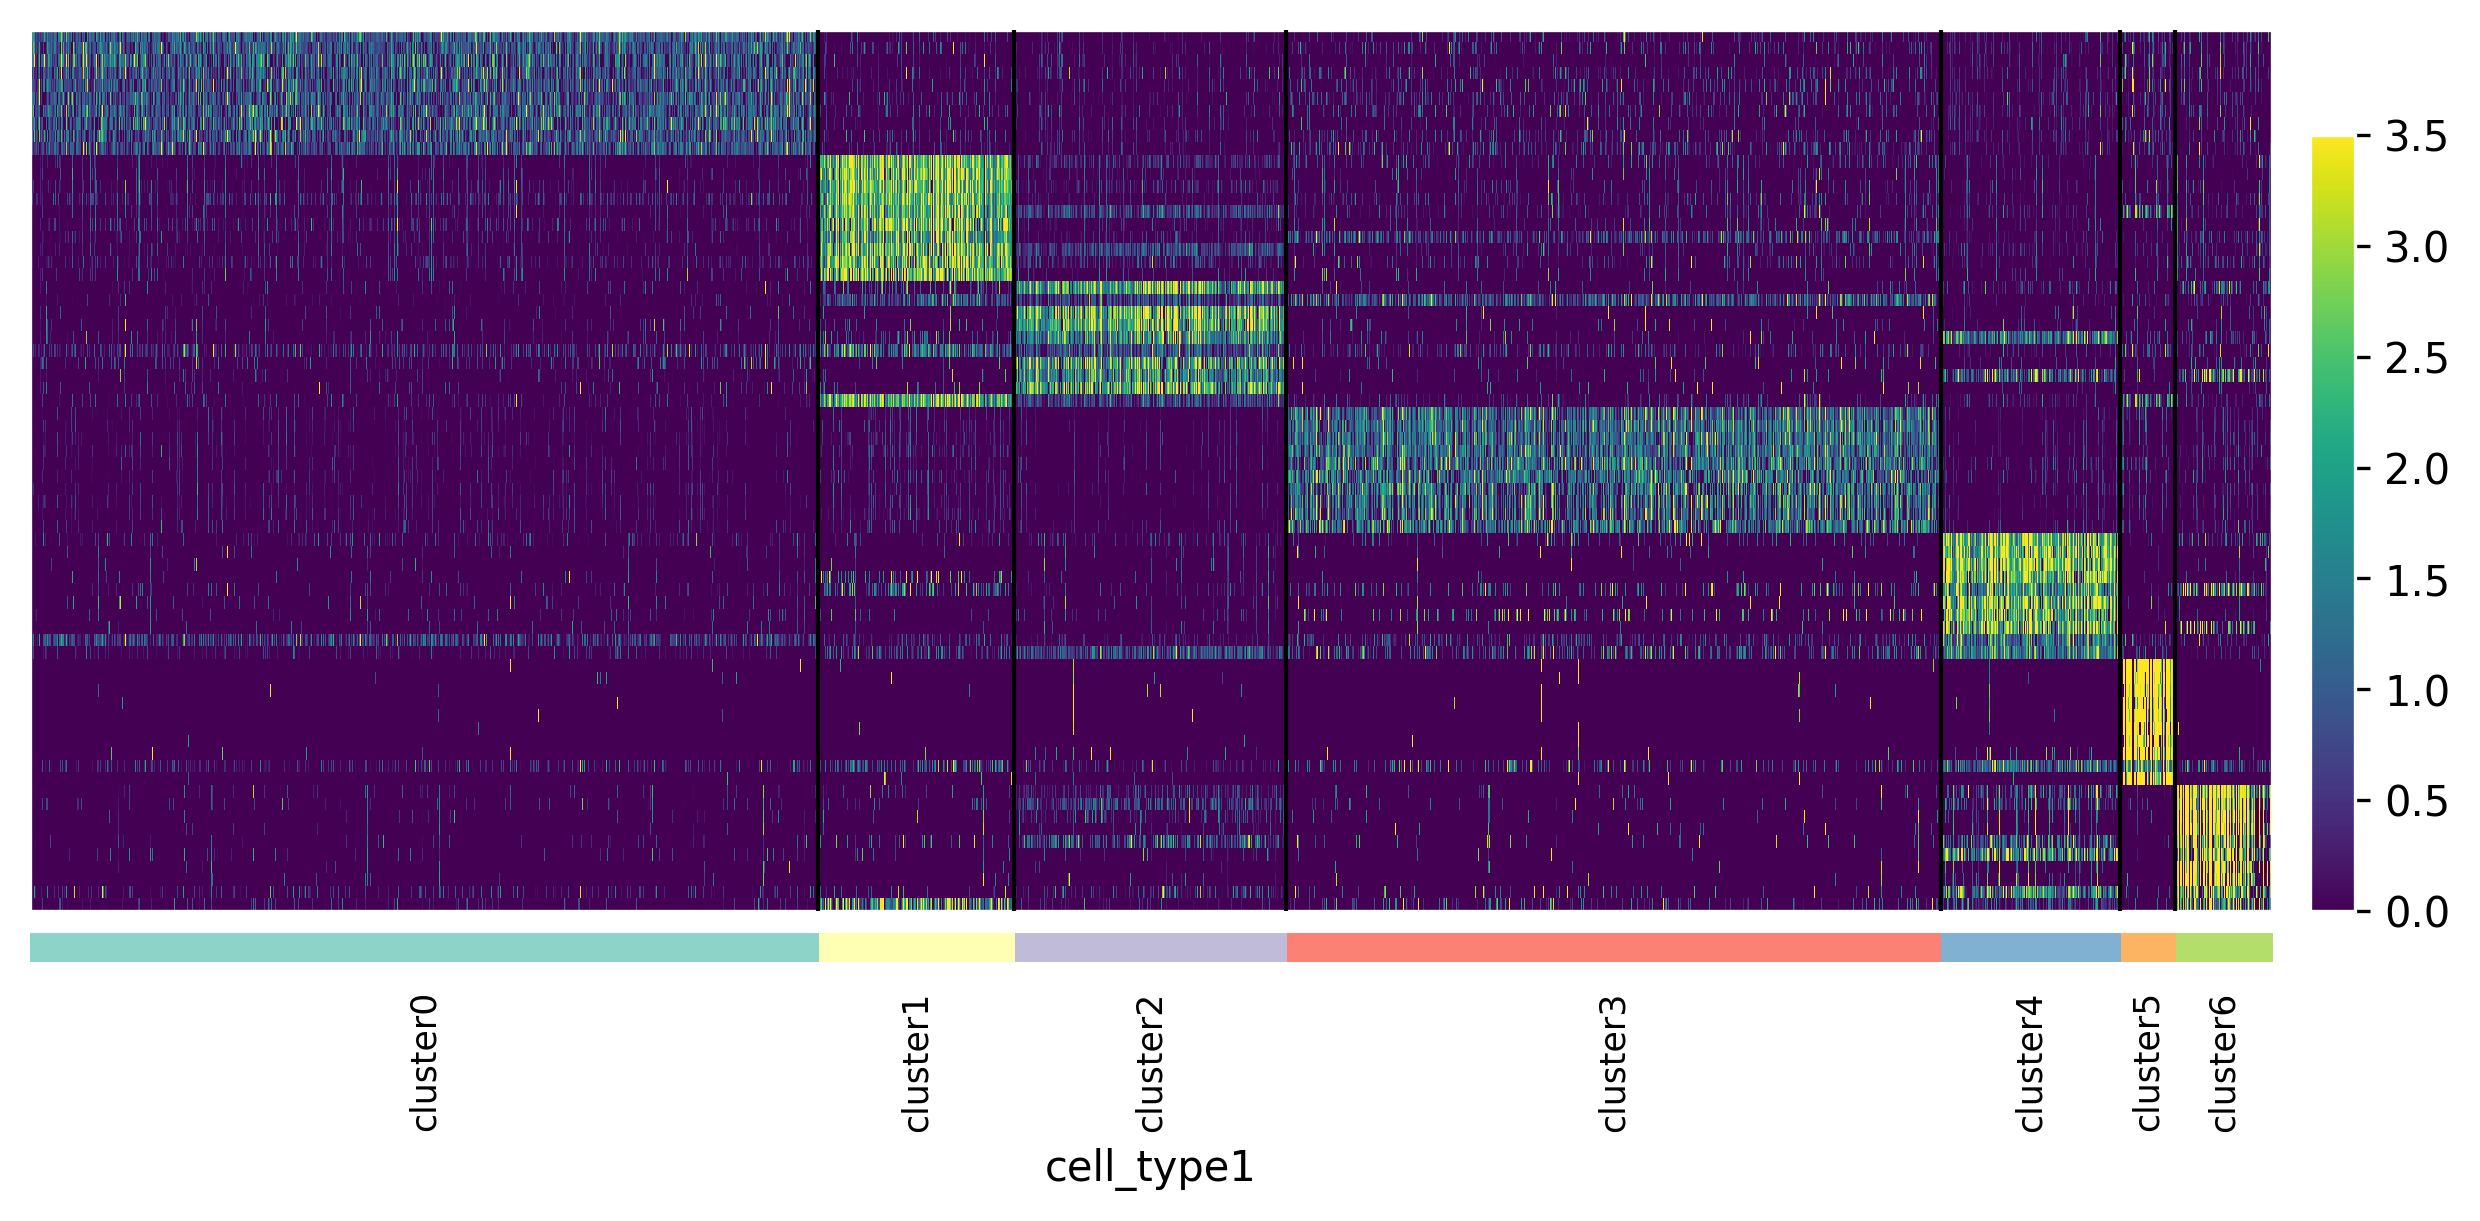

In [21]:
dataset1=adata
clustering=res2    
dataset1.obs['cell_type1'] = clustering

cell_types = dataset1.obs['cell_type1'].unique().tolist()


new_names = {cell_type: f'cluster{i}' for i, cell_type in enumerate(cell_types)}


dataset1.obs['cell_type1'] = dataset1.obs['cell_type1'].map(new_names)
    #dataset1.var_names = list(set(dataset1.var_names))
    #sc.pp.highly_variable_genes(dataset1, n_top_genes=2000)
    #sc.pp.normalize_total(dataset1, target_sum=1e4)
    #sc.pp.log1p(dataset1)

sc.pp.filter_genes(dataset1, min_cells=10)
sc.pp.scale(dataset1, max_value=10)
sc.tl.pca(dataset1, svd_solver='auto')
sc.pp.neighbors(dataset1, n_neighbors=10, n_pcs=40)

sc.tl.rank_genes_groups(dataset1, 'cell_type1', method='t-test', n_genes=10)

    #marker_genes = []
sc.tl.rank_genes_groups(dataset1, 'cell_type1', method='t-test', reference='rest')


marker_genes = {}
for group in dataset1.obs['cell_type1'].cat.categories:
    genes_group = dataset1.uns['rank_genes_groups']['names'][group]
    pvals_group = dataset1.uns['rank_genes_groups']['pvals'][group]

    marker_genes[group] = [gene for gene, pval in zip(genes_group, pvals_group) if pval < 0.05]


selected_genes = []
for genes in marker_genes.values():
    selected_genes.extend(genes[:10])



    #sc.pl.tracksplot(dataset1, marker_genes, groupby='cell_type1', dendrogram=True)
with plt.rc_context({'figure.dpi': 300}):
    sc.pl.heatmap(dataset1, selected_genes, groupby='cell_type1', swap_axes=True, log=False, use_raw=False, cmap='viridis', vmin=0, vmax=3.5)

e:\anaconda\envs\torch_gpu\lib\site-packages\scanpy\plotting\_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


{'mainplot_ax': <Axes: >,
 'group_extra_ax': <Axes: >,
 'gene_group_ax': <Axes: >,
 'size_legend_ax': <Axes: title={'center': 'Fraction of cells\nin group (%)'}>,
 'color_legend_ax': <Axes: title={'center': 'Mean expression\nin group'}>}

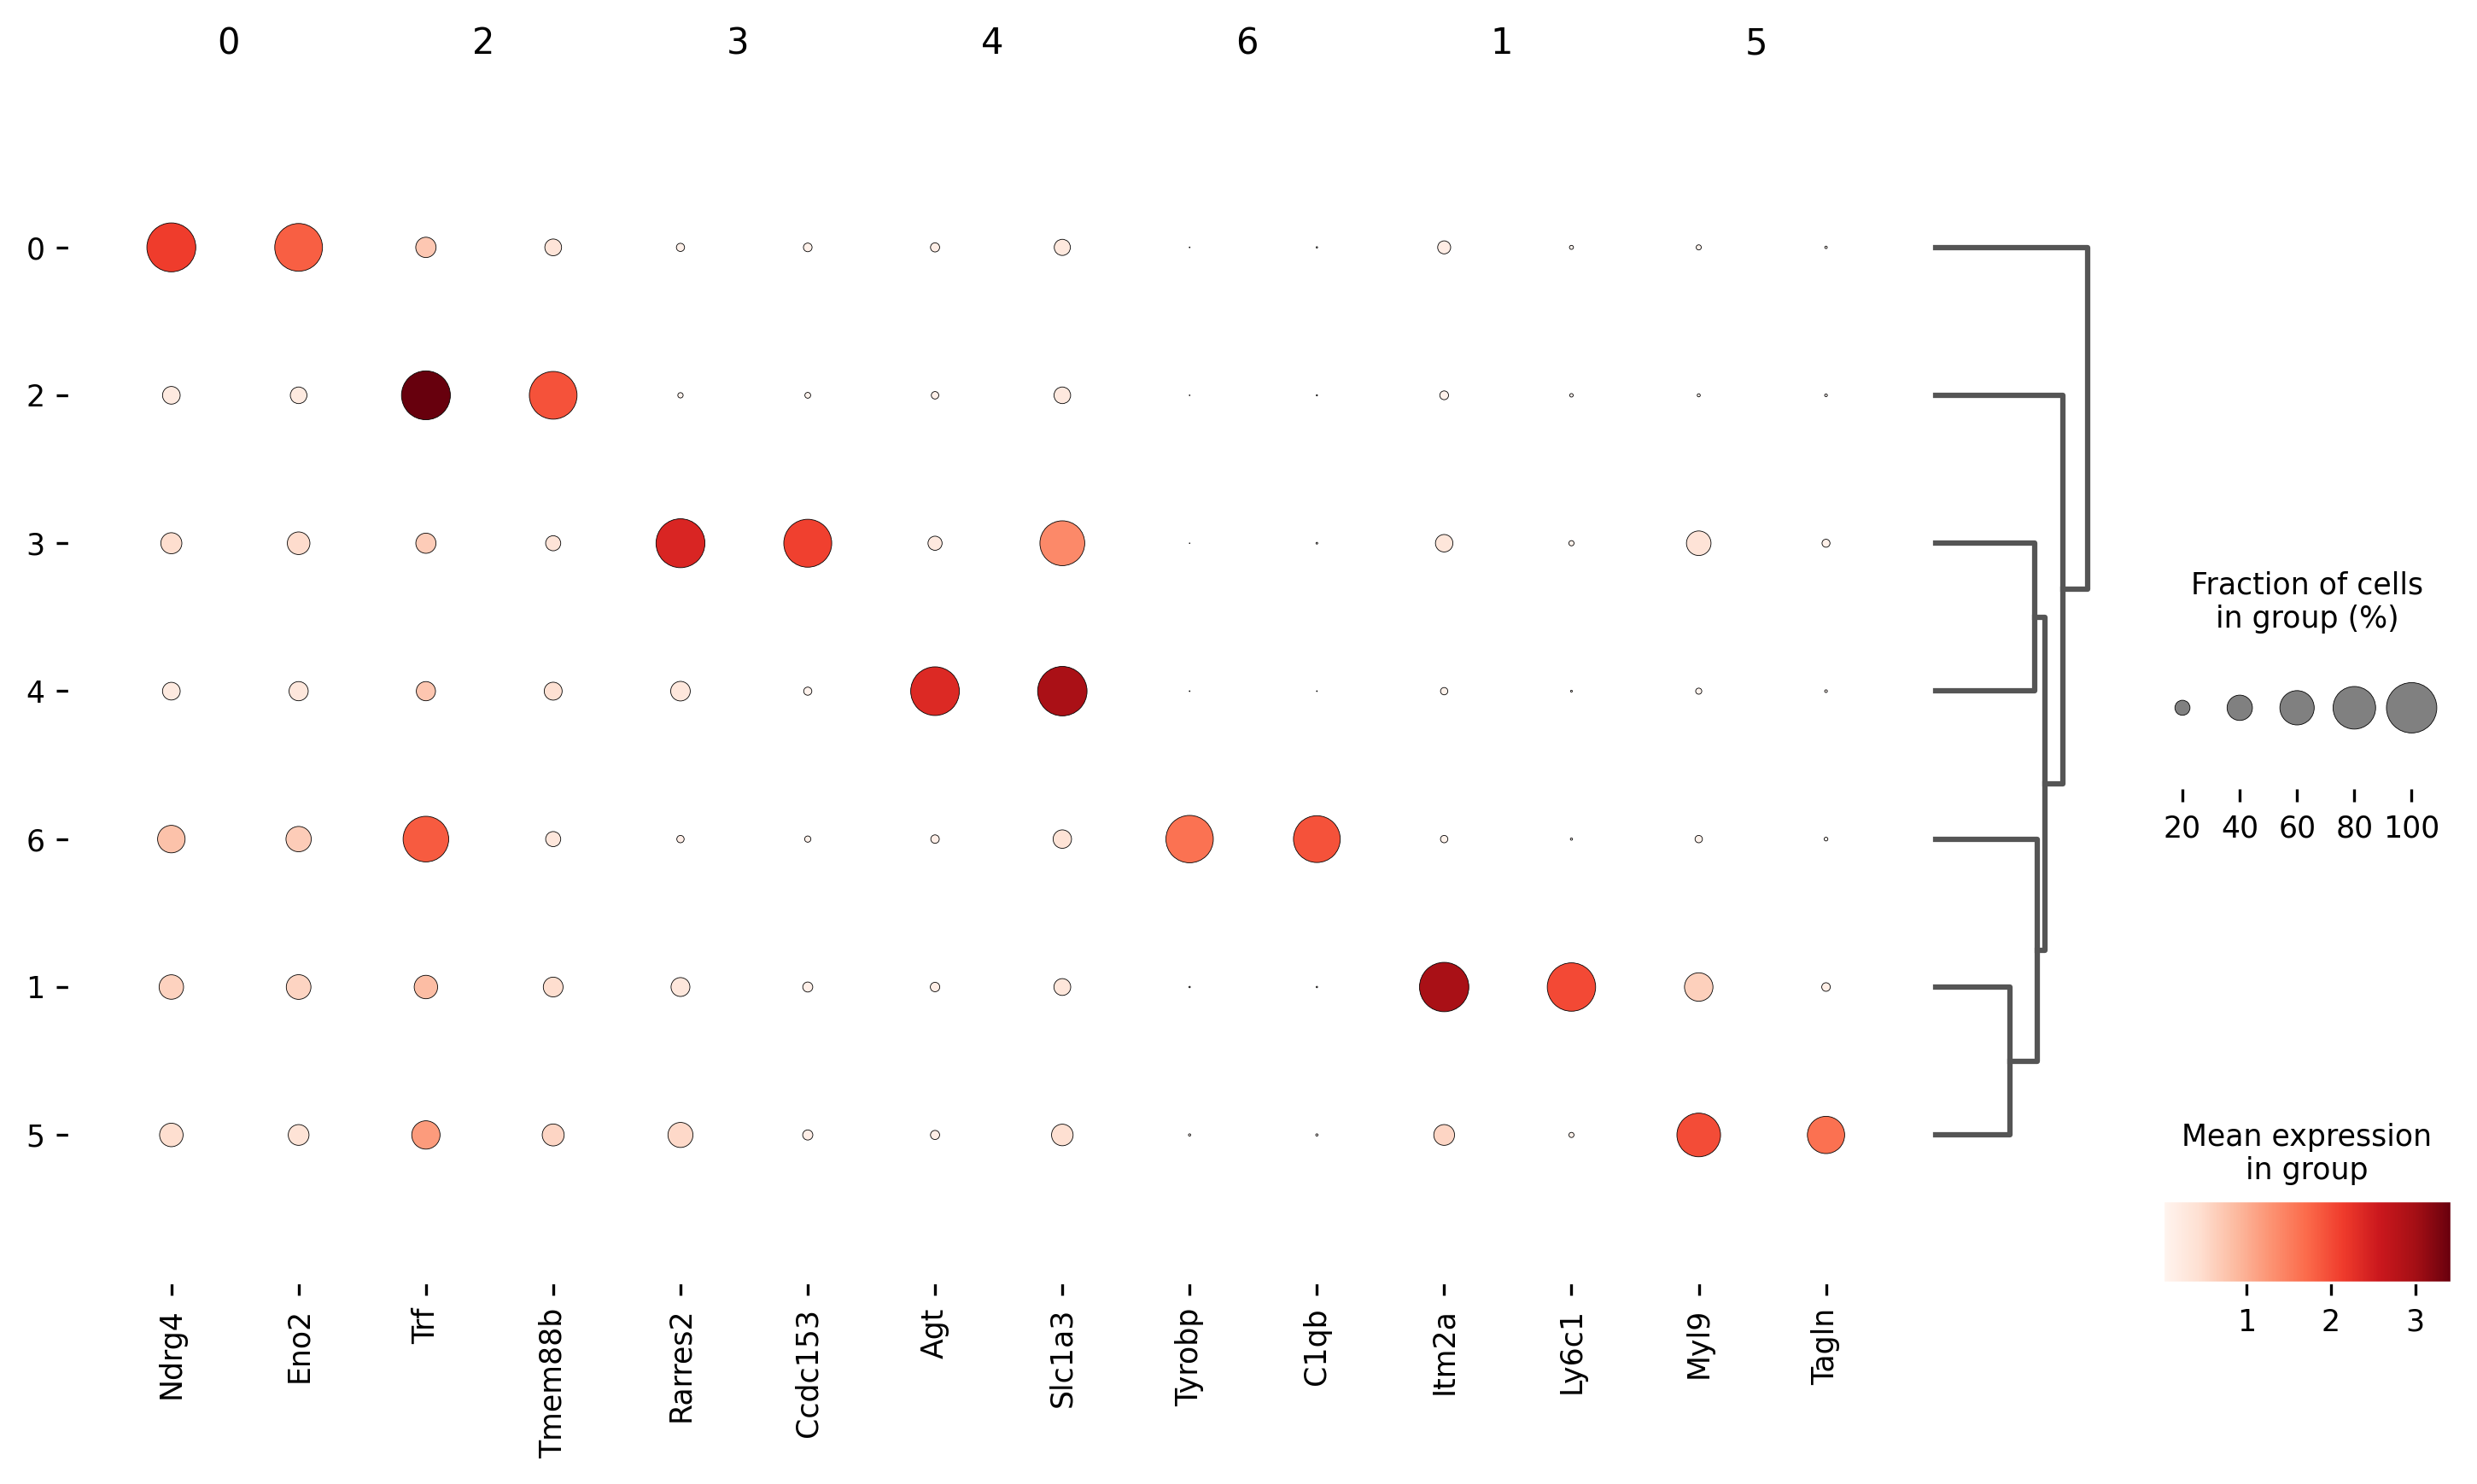

In [ ]:
adata.obs['kmeans_clusters'] = res2.astype(str)

# Convert the kmeans_clusters column to a categorical data type
adata.obs['kmeans_clusters'] = adata.obs['kmeans_clusters'].astype('category')

# Calculate marker genes for each cluster
sc.tl.rank_genes_groups(adata, groupby='kmeans_clusters', method='wilcoxon')
    
# Visualize the ranked genes
sc.pl.rank_genes_groups_dotplot(adata, n_genes=2, figsize=(12,6),show=False)


    'endothelial': ['Ndrg4', 'Eno2'],
    'neurons': ['Tyrobp', 'C1qb'],
    'vsm': ['Itm2a', 'Ly6c1'],
    'astrocytes': ['Trf', 'Tmem88b'],
    'oligos': ['Myl9', 'Crip1'],
    'microglia': ['Agt', 'Slc1a3'],
    'ependymal': ['Rarres2', 'Ccdc153']


In [ ]:
adata.obs['cell_type'] = adata.obs['kmeans_clusters'].replace({
    '0': 'endothelial',
    '1': 'vsm',
    '2': 'ependymal',
    '3': 'astrocytes',
    '4': 'microglia',
    '5': 'oligos',
    '6': 'neurons'   
})


e:\anaconda\envs\torch_gpu\lib\site-packages\scanpy\plotting\_stacked_violin.py:461: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  row_ax = sns.violinplot(
e:\anaconda\envs\torch_gpu\lib\site-packages\scanpy\plotting\_stacked_violin.py:461: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  row_ax = sns.violinplot(
e:\anaconda\envs\torch_gpu\lib\site-packages\scanpy\plotting\_stacked_violin.py:461: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  row_ax = sns.violinplot(
e:\anaconda\envs\torch_gpu\lib\site-packages\scanpy\plotting\_stacked_violin.py:461: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` v

e:\anaconda\envs\torch_gpu\lib\site-packages\scanpy\plotting\_stacked_violin.py:461: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  row_ax = sns.violinplot(
e:\anaconda\envs\torch_gpu\lib\site-packages\scanpy\plotting\_stacked_violin.py:461: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  row_ax = sns.violinplot(
e:\anaconda\envs\torch_gpu\lib\site-packages\scanpy\plotting\_stacked_violin.py:461: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  row_ax = sns.violinplot(


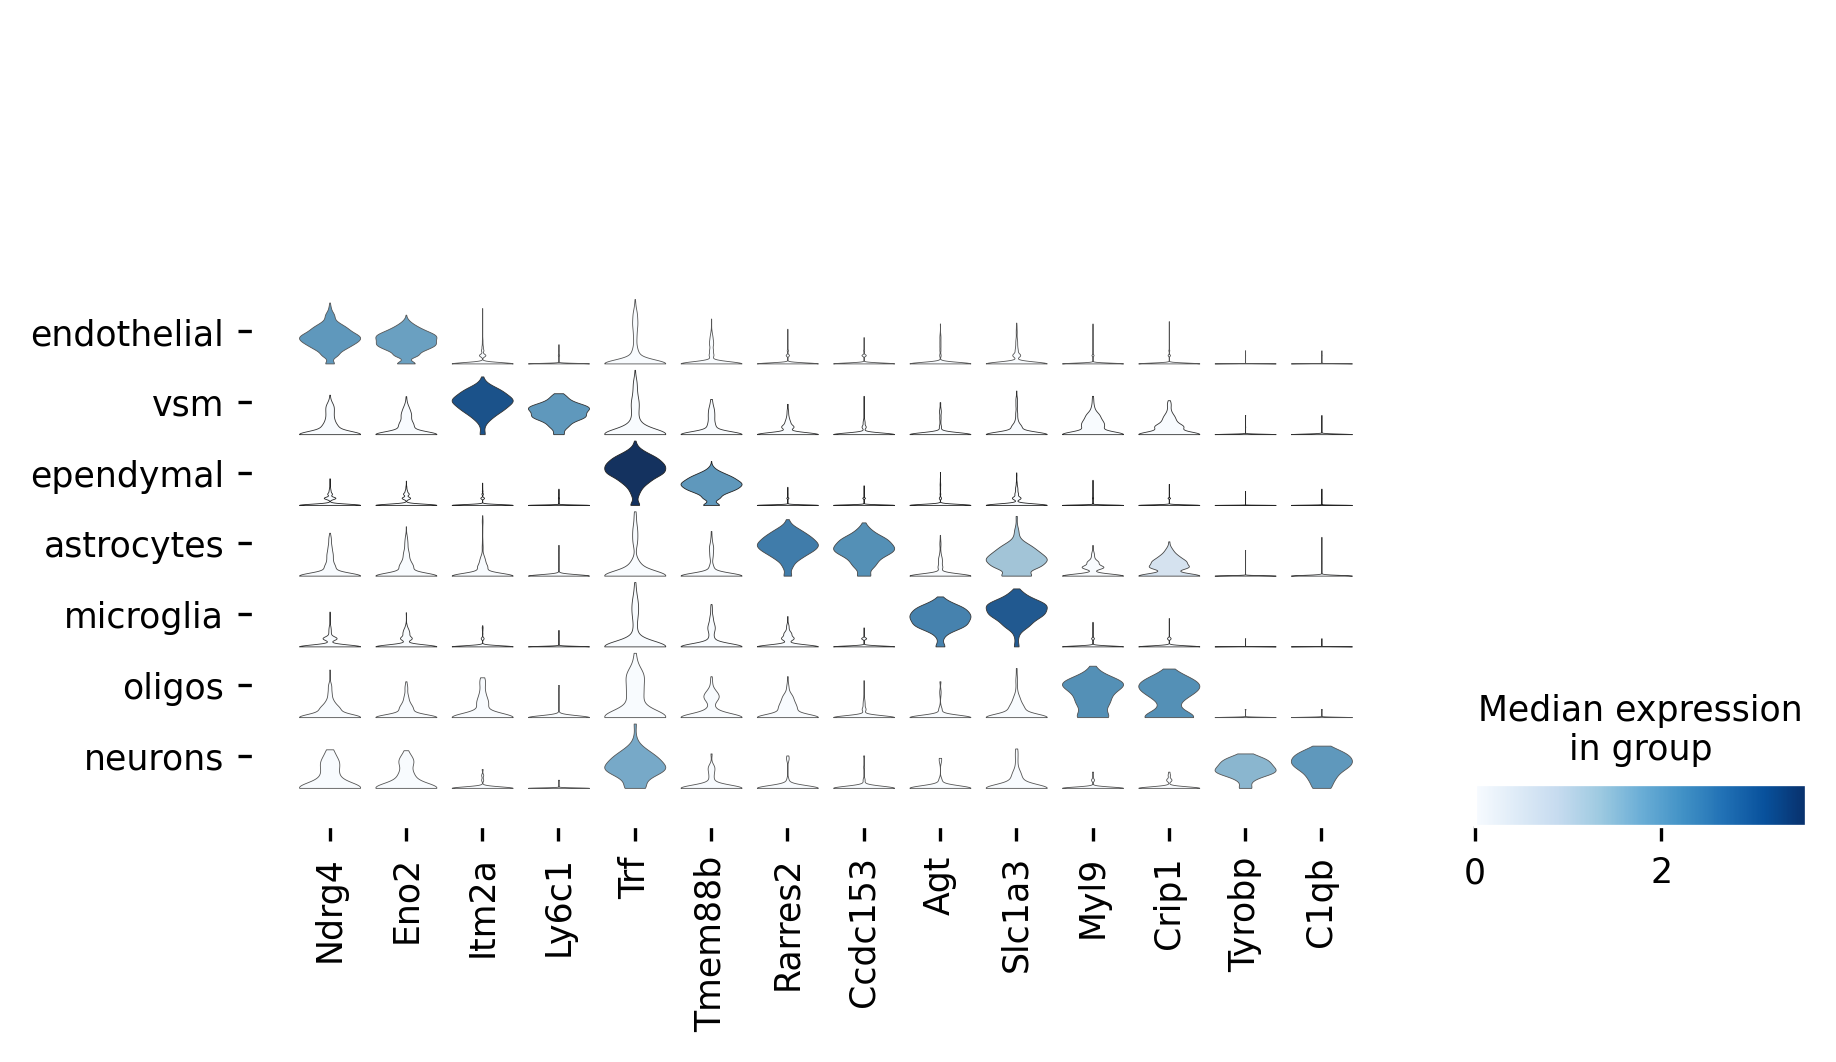

In [ ]:
marker_genes=['Ndrg4','Eno2',
              'Itm2a','Ly6c1',
              'Trf','Tmem88b',
              'Rarres2', 'Ccdc153',
              'Agt','Slc1a3',
              'Myl9','Crip1',
              'Tyrobp','C1qb'              
              ]
sc.pl.stacked_violin(adata, marker_genes, groupby='cell_type',  save='Romanov_vio11.png')

In [ ]:
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(adata)

In [ ]:
sc.tl.paga(adata, groups='cell_type')

e:\anaconda\envs\torch_gpu\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


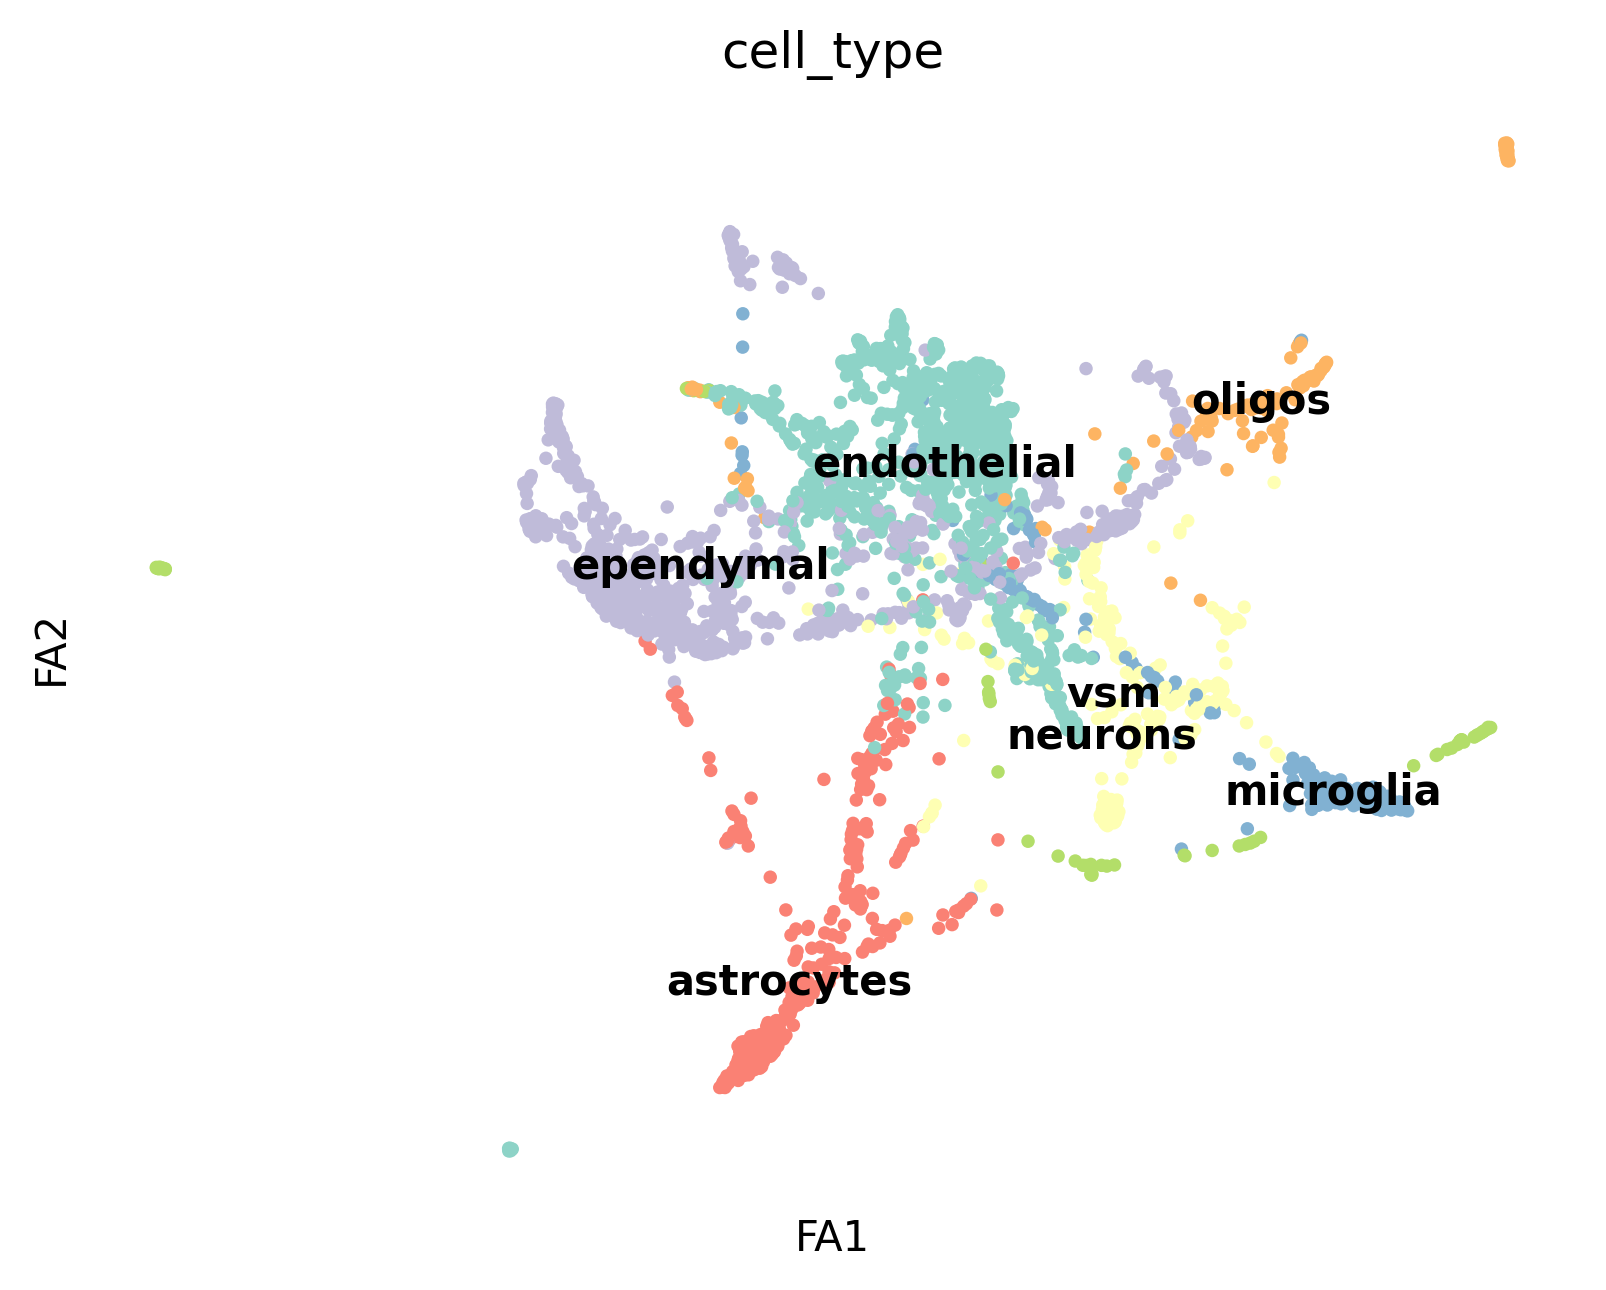

In [ ]:
sc.pl.draw_graph(adata, color='cell_type', legend_loc='on data')

In [ ]:
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')

In [ ]:
sc.tl.draw_graph(adata)

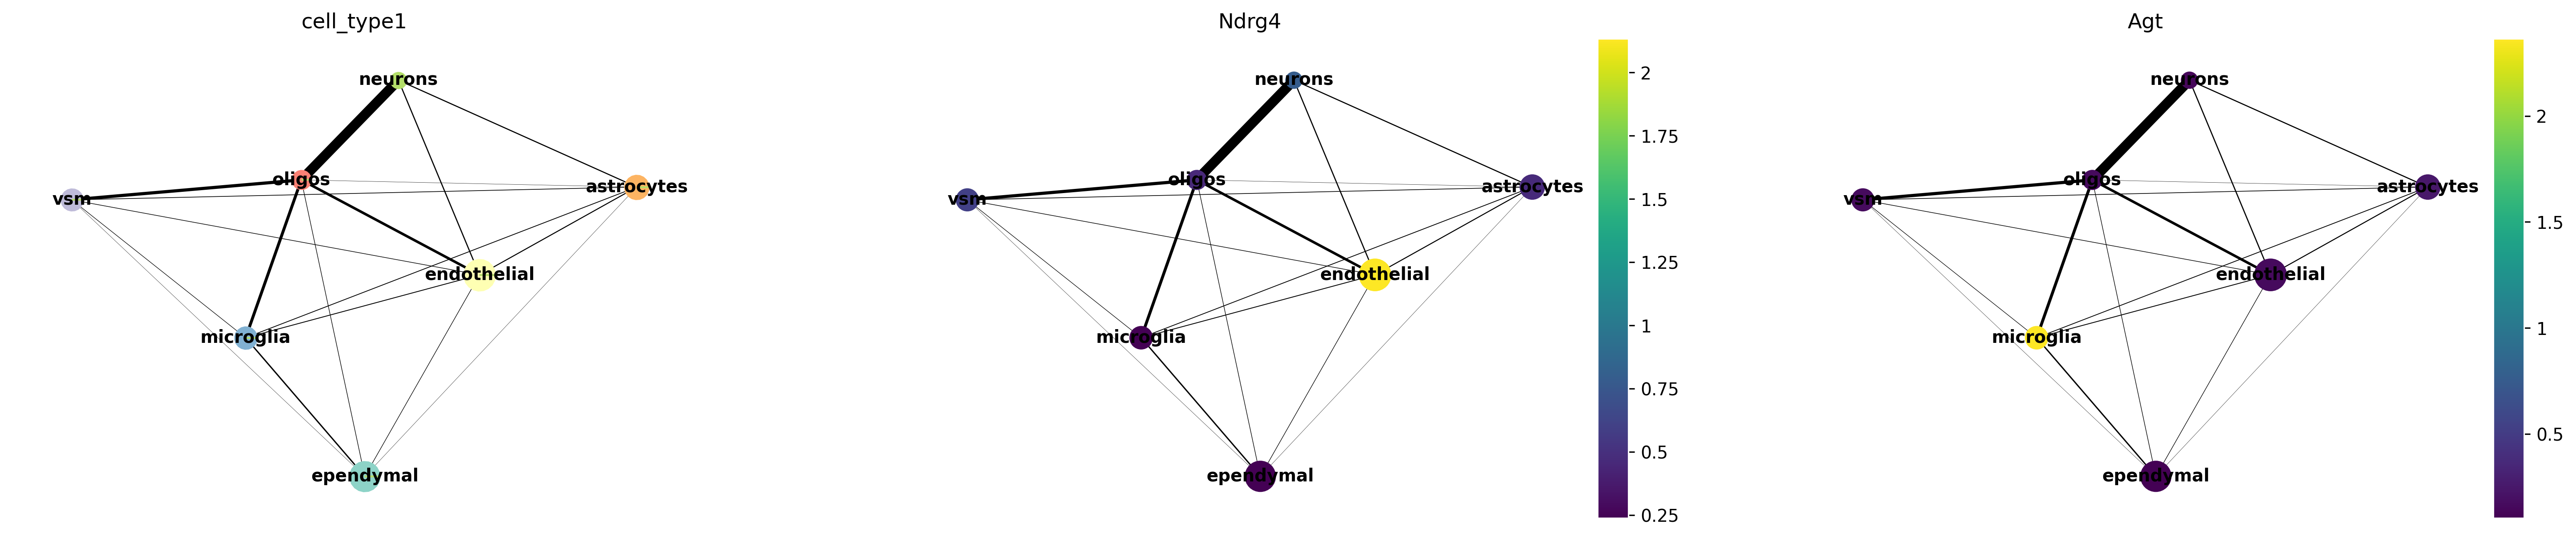

In [ ]:
sc.pl.paga(adata, color=['cell_type1', 'Ndrg4','Agt'])

In [ ]:
sc.tl.draw_graph(adata, init_pos='paga')

e:\anaconda\envs\torch_gpu\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


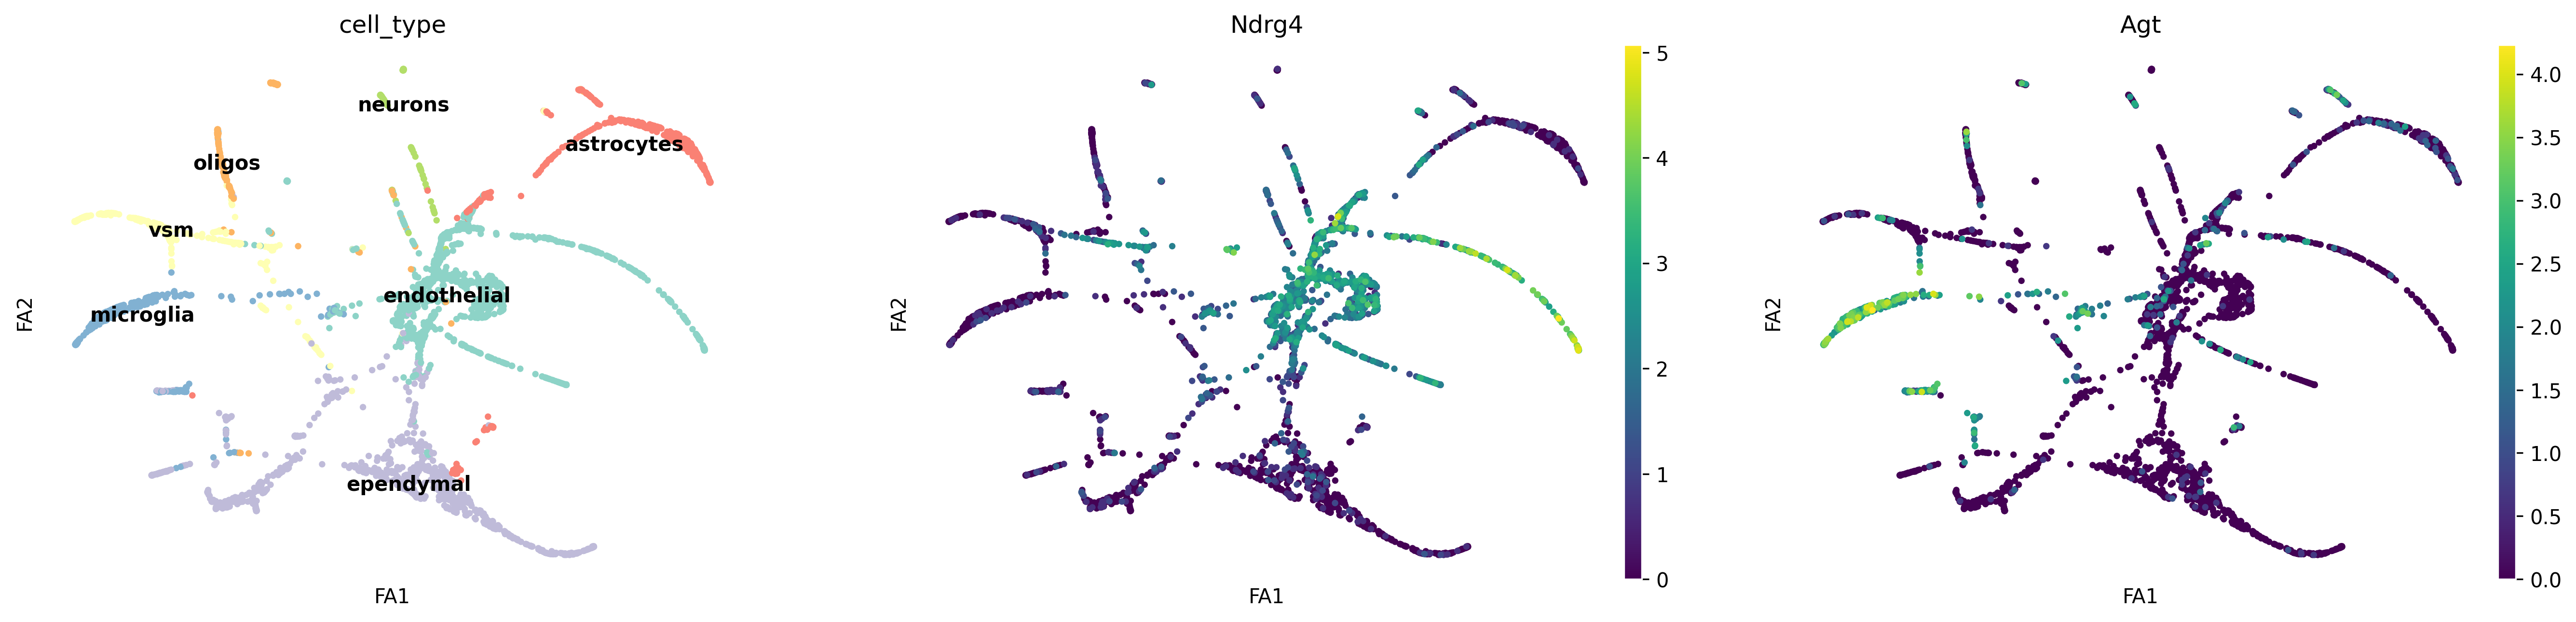

In [ ]:
sc.pl.draw_graph(adata, color=['cell_type', 'Ndrg4','Agt'], legend_loc='on data')